# Load Dataset

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import cross_val_score


In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="aFrVbcrqu4udJMVQrCGz")
project = rf.workspace("segment1-yellowbanana").project("waste-identification-a3v9y")
version = project.version(1)
dataset = version.download("folder")



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Waste-identification-1 in folder:: 100%|██████████| 13067/13067 [00:01<00:00, 8435.52it/s]


In [ ]:
PATH = "/content/Waste-identification-1/"

def load_dataset(PATH):
    images = []
    labels = []
    class_names = sorted(os.listdir(PATH))
    for idx, class_name in enumerate(class_names):
        class_folder = os.path.join(PATH, class_name)
        if os.path.isdir(class_folder):
            for file_name in os.listdir(class_folder):
                file_path = os.path.join(class_folder, file_name)
                img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    images.append(img)
                    if idx < len(class_names):
                        labels.append(idx)
                    else:
                        print(f"Warning: Found a label index {idx} which is out of range for class_names")
    return np.array(images), np.array(labels), class_names


In [ ]:
train_images, train_labels, class_names = load_dataset(PATH + 'train')
val_images, val_labels, class_names = load_dataset(PATH + 'valid')
test_images, test_labels, class_names = load_dataset(PATH + 'test')

print(f"Loaded {len(train_images)} images with labels {len(train_labels)}.")
print(f"Loaded {len(val_images)} images with labels {len(val_labels)}.")
print(f"Loaded {len(test_images)} images with labels {len(test_labels)}.")

Loaded 12039 images with labels 12039.
Loaded 503 images with labels 503.
Loaded 502 images with labels 502.


In [ ]:
print(class_names)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


# Preprocess

In [ ]:
RESIZE_DIM = 256

train_images_resized = np.array([cv2.resize(img, (RESIZE_DIM, RESIZE_DIM)) for img in train_images])
val_images_resized = np.array([cv2.resize(img, (RESIZE_DIM, RESIZE_DIM)) for img in val_images])
test_images_resized = np.array([cv2.resize(img, (RESIZE_DIM, RESIZE_DIM)) for img in test_images])


# Feature Extraction

In [ ]:
def extract_features(images):
    features = []
    for img in images:
        if len(img.shape) == 2:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            img_rgb = img

        moments = cv2.HuMoments(cv2.moments(img)).flatten()

        glcm = graycomatrix(img, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
        contrast = graycoprops(glcm, 'contrast')[0, 0]
        dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
        homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
        ASM = graycoprops(glcm, 'ASM')[0, 0]

        hist_r = cv2.calcHist([img_rgb], [0], None, [256], [0, 256]).flatten()
        hist_g = cv2.calcHist([img_rgb], [1], None, [256], [0, 256]).flatten()
        hist_b = cv2.calcHist([img_rgb], [2], None, [256], [0, 256]).flatten()

        hist_r = hist_r / np.sum(hist_r)
        hist_g = hist_g / np.sum(hist_g)
        hist_b = hist_b / np.sum(hist_b)

        combined_features = np.hstack([moments, contrast, dissimilarity, homogeneity, ASM, hist_r, hist_g, hist_b])
        features.append(combined_features)

    return np.array(features)


In [ ]:
train_features = extract_features(train_images_resized)
val_features = extract_features(val_images_resized)
test_features = extract_features(test_images_resized)

In [ ]:
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
val_features_scaled = scaler.transform(val_features)
test_features_scaled = scaler.transform(test_features)

# Split Dataset

In [ ]:
X_train = train_features_scaled
X_val = val_features_scaled
X_test = test_features_scaled
y_train = train_labels
y_val = val_labels
y_test = test_labels

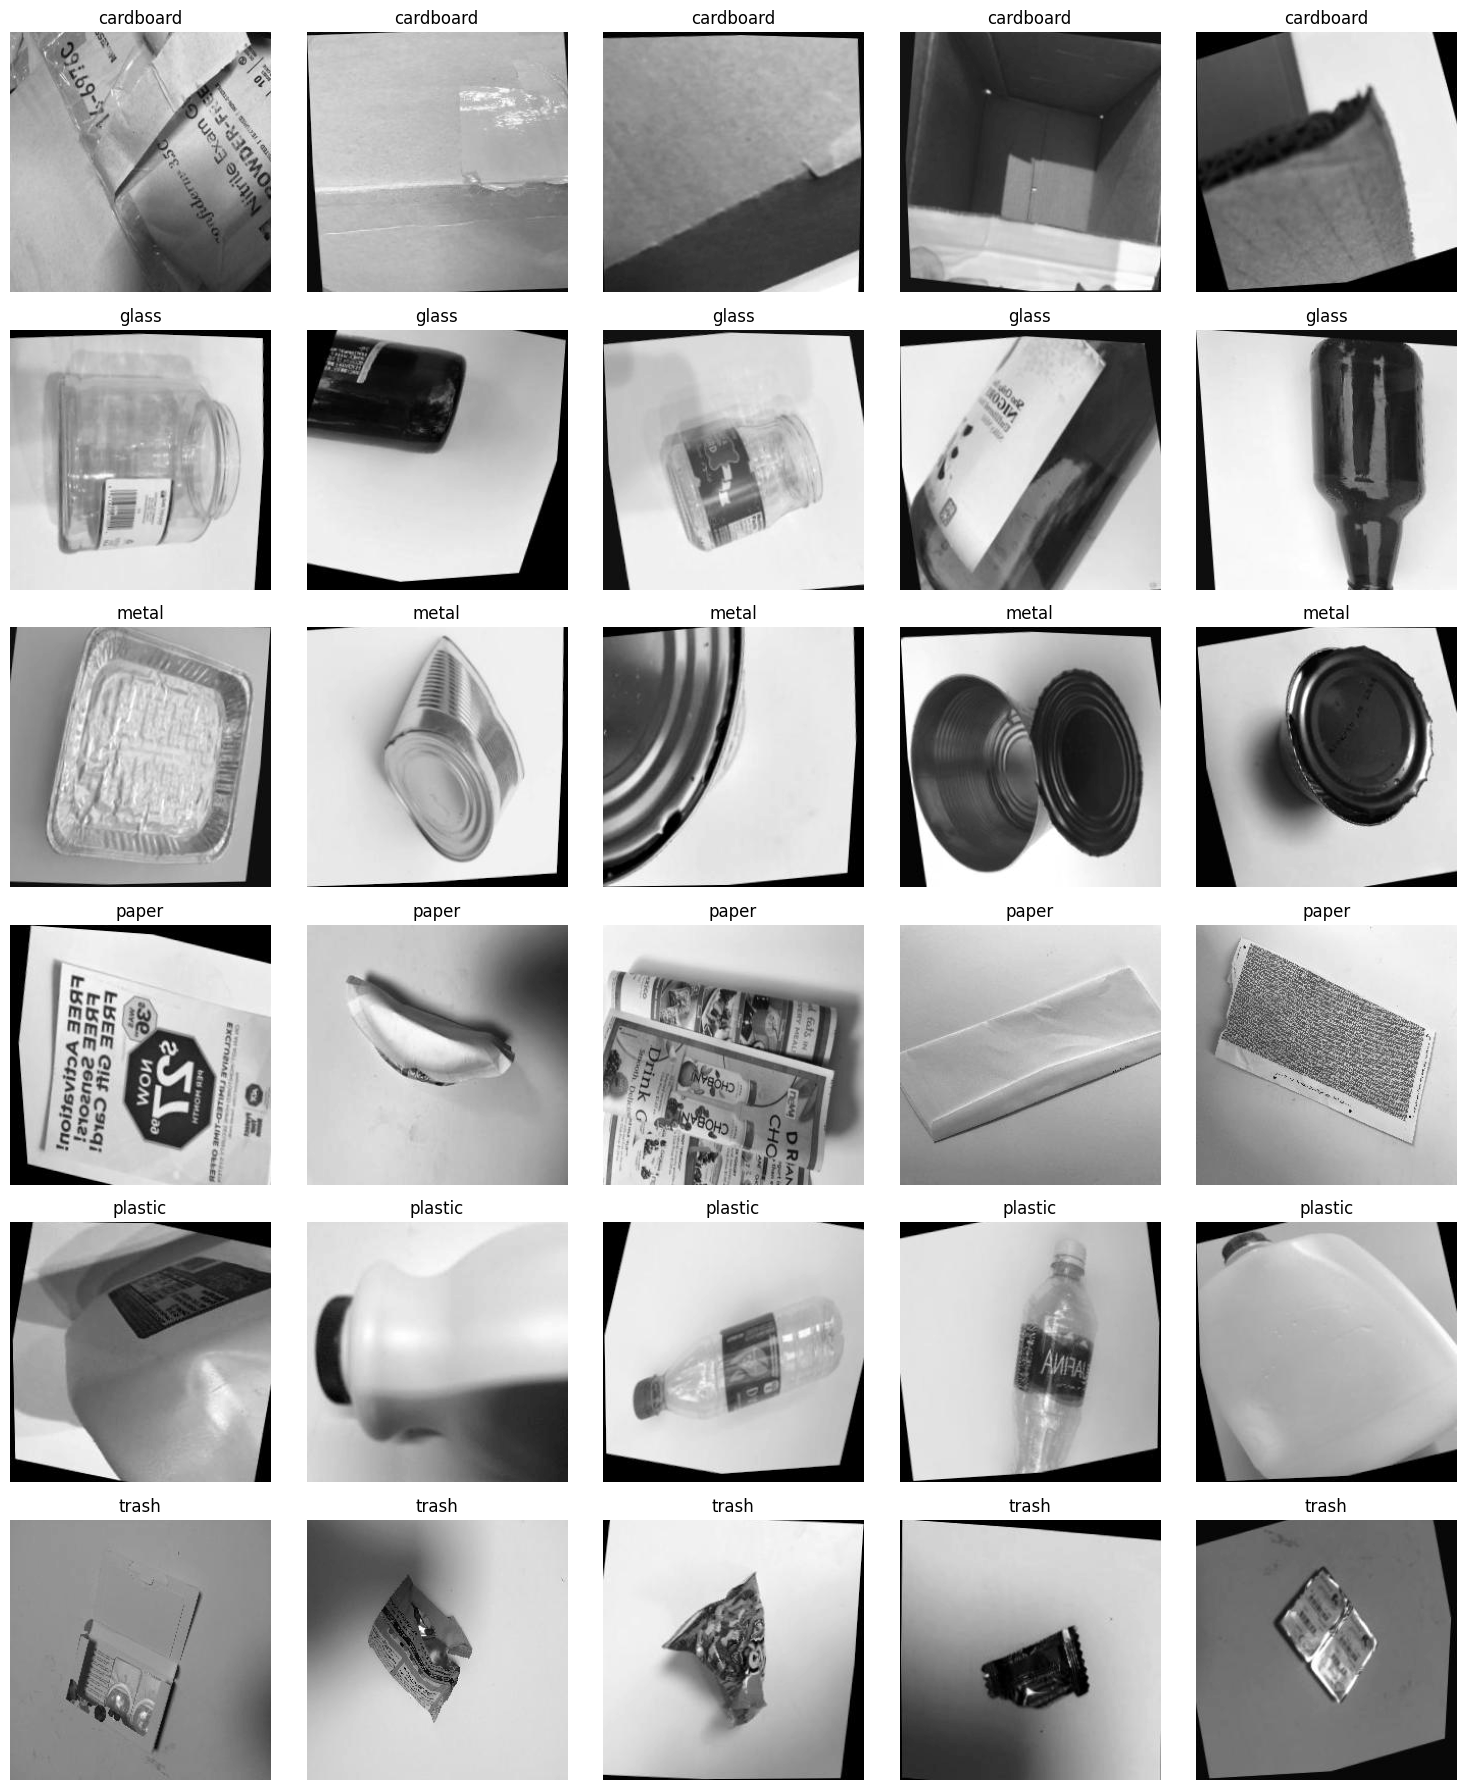

In [ ]:
def plot_sample_images(images, labels, class_names, samples_per_class=5):
    plt.figure(figsize=(15, len(class_names) * 3))
    for i, class_name in enumerate(class_names):
        class_indices = np.where(labels == i)[0]
        selected_indices = class_indices[:samples_per_class]
        for j, idx in enumerate(selected_indices):
            plt.subplot(len(class_names), samples_per_class, i * samples_per_class + j + 1)
            plt.imshow(images[idx], cmap='gray')
            plt.title(class_name)
            plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_sample_images(train_images_resized, y_train, class_names, samples_per_class=5)


In [ ]:
def count_and_print_distributions(labels, set_name, class_names):
    class_counts = pd.DataFrame(
        {
            "Class": [class_names[label] for label in labels],
            "Count": 1
        }
    ).groupby("Class").count().reset_index()
    class_counts["Dataset"] = set_name
    print(f"\n{set_name} set class distribution:")
    print(class_counts)
    return class_counts

train_class_counts = count_and_print_distributions(y_train, "Train", class_names)
val_class_counts = count_and_print_distributions(y_val, "Validation", class_names)
test_class_counts = count_and_print_distributions(y_test, "Test", class_names)



Train set class distribution:
       Class  Count Dataset
0  cardboard   1905   Train
1      glass   2391   Train
2      metal   1986   Train
3      paper   2835   Train
4    plastic   2292   Train
5      trash    630   Train

Validation set class distribution:
       Class  Count     Dataset
0  cardboard     78  Validation
1      glass    100  Validation
2      metal     86  Validation
3      paper    121  Validation
4    plastic     86  Validation
5      trash     32  Validation

Test set class distribution:
       Class  Count Dataset
0  cardboard     85    Test
1      glass     95    Test
2      metal     69    Test
3      paper    113    Test
4    plastic    110    Test
5      trash     30    Test


# Training

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)


In [ ]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=42)

# Evaluation

In [ ]:
y_train_pred = rf_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
y_val_pred = rf_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)

y_test_pred = rf_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Val Accuracy: {val_accuracy:.2f}")

class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
print(classification_report(y_test, y_test_pred, target_names=class_names))

Training Accuracy: 0.85
Val Accuracy: 0.73
              precision    recall  f1-score   support

   cardboard       0.84      0.69      0.76        85
       glass       0.69      0.77      0.73        95
       metal       0.63      0.72      0.68        69
       paper       0.78      0.86      0.82       113
     plastic       0.72      0.74      0.73       110
       trash       1.00      0.37      0.54        30

    accuracy                           0.74       502
   macro avg       0.78      0.69      0.71       502
weighted avg       0.75      0.74      0.74       502



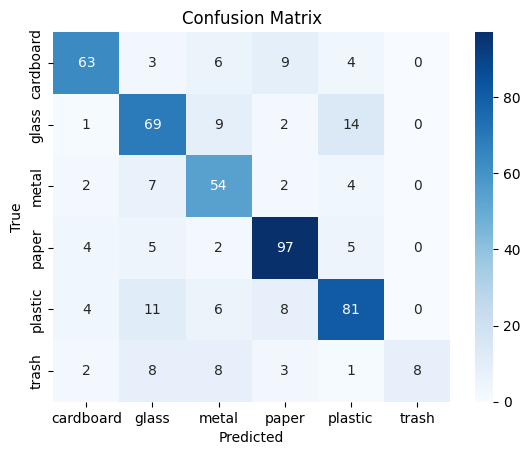

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


# Save Model

In [ ]:
from google.colab import files
import joblib, pickle

model_filename = '/content/Random-forest_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(rf_model, file)
print("Model is saved")
files.download(model_filename)

Model is saved


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
class_names_filename = '/content/Random-forest_class_names74.pkl'
with open(class_names_filename, 'wb') as file:
    pickle.dump(class_names, file)
print("Class names is saved")
files.download(class_names_filename)

Class names is saved


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
scaler_filename = '/content/Random-forest_scaler74.pkl'
with open(scaler_filename, 'wb') as file:
    pickle.dump(scaler, file)
print("scaler is saved")
files.download(scaler_filename)


scaler is saved


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>